<a href="https://colab.research.google.com/github/zzz0023/QAOA-with-Qiskit/blob/main/Qiskit_QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

This notebook aims to study the use of qiskit in QAOA and the application in max-cut problem. Section 1 focus on the discussion on QAOA. Section 2 focuses on the use of IBM cloud and runtime service to solve the 5-nodes max-cut problem. Section 3 deals with the same problem as section 2, but with a method that could run locally. Section 4 contain some discussion about larger scale QAOA. Section 5 applies a new method named as QAOA in QAOA, aiming to provide a possible alternative method when solving larger scale problem.

The following code requires the listed packages:
* Qiskit SDK v1.1.1 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* Rustworkx graph library (`pip install rustworkx`)

In [ ]:
!pip install 'qiskit[visualization]'
!pip install qiskit-ibm-runtime
!pip install rustworkx

# Section 1: Steps for QAOA

## Step 1. Map classical inputs to a quantum problem

The first step of the pattern is to map the classical problem (graph) into quantum **circuits** and **operators**. To do this, there are three main steps to take:

1. Utilize a series of mathematical reformulations, to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.
2. Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function.
3. Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.

### Question → Optimization problem → Hamiltonian → quantum circuit

## Step 2. Optimize circuits for quantum hardware execution

**(This step can be skipped if the circuit is only for modelling instead of runing in a real QPU)**

Usually, the quantum circuit derived from the Hamiltonian is hard to be processed in a real-world quantum device. Therefore, to be able to run on a QPU, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern. The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. You need to make sure that your circuit is **optimized** for your purpose.

Transpilation may involves several steps, such as:

* **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device.
* **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
* **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
* **Error suppression** by adding single-qubit gates to suppress noise with dynamical decoupling.

The following code transforms and optimizes the abstract circuit into a format that is ready for execution on one of devices accessible through the cloud using the **Qiskit IBM Runtime service**.

The IBM cloud service requires a ibm account and its token, which can be obtained through the following link:

https://www.ibm.com/blog/tokens-and-login-sessions-in-ibm-cloud/

## Step 3. Execute using Qiskit primitives

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. This execution loop is executed via the following steps:

1. Define the initial parameters
2. Instantiate a new `Session` containing the optimization loop and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.


## Step 4. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for your original problem. To illustrate this, the max-cut problem will be used as an example in section 2.

# Section 2: Application on Max-cut Problem

The Max-Cut problem is an optimization problem that is hard to solve (more specifically, it is an *NP-hard* problem) with a number of different applications in clustering, network science, and statistical physics. This tutorial considers a graph of nodes connected by vertices, and aims to partition it into separate graphs such that they are both as large as possible. Put another way, the goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized.

![Illustration of a max-cut problem](https://learning-api.quantum.ibm.com/assets/0de75f52-4873-4b5a-a0e9-a351dc48c910)Figure 1: Illustration of a max cut problem with 5 nodes


### Question → Optimization problem
To give some context before mapping the small scale max cut problem to a quantum algorithm, you can better understand how the Max-Cut problem becomes a classical combinatorial optimization problem by first considering the minimization of a function $f(x)$

$$
\min_{x\in \{0, 1\}^n}f(x),
$$

where the input $x$ is a vector whose components correspond to each node of a graph.  Then, constrain each of these components to be either $0$ or $1$ (which represent being included or not included in the cut). This small-scale example case uses a graph with $n=5$ nodes (figure 1).

You could write a function of a pair of nodes $i,j$ which indicates whether the corresponding edge $(i,j)$ is in the cut. For example, the function $x_i + x_j - 2 x_i x_j$ is 1 only if one of either $x_i$ or $x_j$ are 1 (which means that the edge is in the cut) and zero otherwise. The problem of maximizing the edges in the cut can be formulated as

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
$$

which can be rewritten as a minimization of the form

$$
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
$$

The minimum of $f(x)$ in this case is when the number of edges traversed by the cut is maximal.



Initialize the problem by creating a graph with $n=5$ nodes.

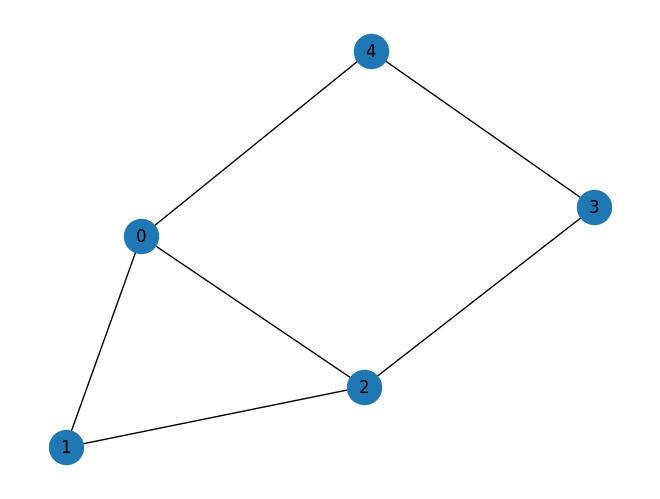

In [ ]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

### Optimization problem → Hamiltonian

You can then reformulate the QUBO problem as a **Hamiltonian** (here, a matrix that represents the energy of a system):

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

> **Reformulation steps from the QAOA problem to the Hamiltonian**

> To demonstrate how the QAOA problem can be rewritten in this way, first replace the binary variables $x_i$ to a new set of variables $z_i\in\{-1, 1\}$ via
>
> $$
> x_i = \frac{1-z_i}{2}.
> $$
>
> Here you can see that if $x_i$ is $0$, then $z_i$ must be $1$. When the $x_i$'s are substituted for the $z_i$'s in the optimization problem ($x^TQx$), an equivalent formulation can be obtained.
>
> $$
> x^TQx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
> $$
>
> Now if we define $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$, remove the prefactor, and the constant $n^2$ term, we arrive at the two equivalent formulations of the same optimization problem.
>
> $$
> \min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
> $$
>
> Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped the factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization.
>
> Now, to obtain a quantum formulation of the problem, promote the $z_i$ variables to a Pauli $Z$ matrix, such as a $2\times 2$ matrix of the form
>
> $$
> Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
> $$
>
> When you substitute these matrices in the optimization problem above, you obtain the following Hamiltonian
>
> $$
> H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
> $$
>
> *Also recall that the $Z$ matrices are embedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ embedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.*

This Hamiltonian is called the <b>cost function Hamiltonian</b>. It has the property that its ground state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve your optimization problem you now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min~f(x)$.


In [ ]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### Hamiltonian → quantum circuit

The Hamiltonian $H_c$ contains the quantum definition of your problem. Now you can create a quantum circuit that will help *sample* good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.

The general idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that you are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$.

The quantum circuit that you generate is **parametrized** by $\gamma_i$ and $\beta_i$, so you can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.

![Circuit diagram with QAOA layers](https://learning-api.quantum.ibm.com/assets/29a70f21-b453-4df7-b726-19468e5b1f51)

In this case, you will try an example with one QAOA layer that contains two parameters: $\gamma_1$ and $\beta_1$.


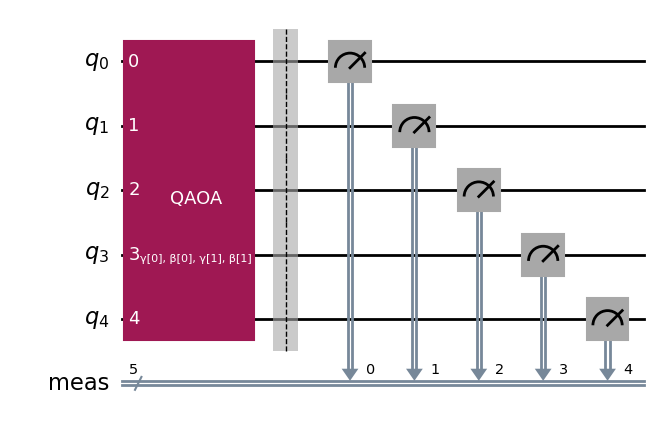

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [ ]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### Optimise the quantum circuit

Use the ibm cloud service to optimise the circuit.

<IBMBackend('ibm_sherbrooke')>


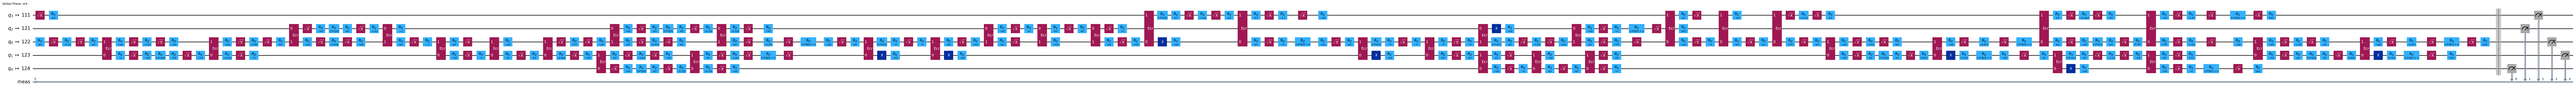

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# This token requires on time update
my_ibm_token = "f06dba1a28295c2204e1999ffc2183e82cadbaa529ec75376be9f4ef184033deabb02bb5da206f2d6b8b713928abec6ae6ed895f5a34be84f77df78fd0931b08"

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum', token=my_ibm_token)
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend,
                                    translation_method='translator')

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

### Execute using Qiskit primitives

We start with arbitrary chosen parameters.


In [ ]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

Then, define backend and execution primitive. Use the **Qiskit Runtime primitives** to interact with IBM® backends. The two primitives are Sampler and Estimator, and the choice of primitive depends on what type of measurement you want to run on the quantum computer. For the minimization of $H_c$, use the Estimator since the measurement of the cost function is simply the expectation value of $\langle H_c \rangle$.


The primitives offer a variety of [execution modes](https://docs.quantum.ibm.com/run/execution-modes) to schedule workloads on quantum devices, and a QAOA workflow runs iteratively in a session.

![Illustration showing the behavior of Single job, Batch, and Session runtime modes.](https://learning-api.quantum.ibm.com/assets/73e400b1-e5a9-4ee8-9842-3e2bbfbef3f5)

You can plug the sampler-based cost function into the SciPy minimizing routine to find the optimal parameters.


In [ ]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

The following step aims to optimize the parameter using ibm runtime service. However, for a free account the waiting time is about 1 hour. So, usually this step can be skiped and we assume that the parameter is optimised.

In [ ]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

The following is the expect output of the above coding:

message: Optimization terminated successfully.

success: True

status: 1

fun: -1.9252549900345741

x: [ 3.271e+00  2.874e+00  2.641e+00  9.339e-01]

nfev: 35

maxcv: 0.0

**The value of x are the optimised parameters.**

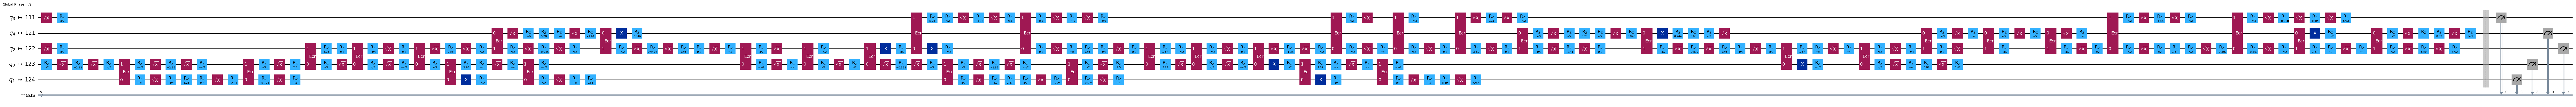

In [ ]:
optimised_params = [ 3.271e+00,  2.874e+00,  2.641e+00,  9.339e-01]
optimized_circuit = candidate_circuit.assign_parameters(optimised_params)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

Again, the following coding uses ibm_runtime service to optimise the distribution and look for the final result, which requires long queue time. So, the result is shown after the coding.

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)


In [ ]:
final_distribution_int = {16: 0.0356, 18: 0.0753, 10: 0.0456, 21: 0.0456, 8: 0.0159, 19: 0.0288, 17: 0.0385, 1: 0.0234, 11: 0.0955, 31: 0.0038, 22: 0.0732, 28: 0.0137, 20: 0.08, 9: 0.0977, 6: 0.0138, 30: 0.0102, 2: 0.0127, 26: 0.0532, 13: 0.0354, 27: 0.0114, 0: 0.0087, 4: 0.0092, 5: 0.0432, 14: 0.0195, 25: 0.0196, 3: 0.0264, 24: 0.0128, 12: 0.0164, 15: 0.0094, 23: 0.009, 7: 0.0111, 29: 0.0054}

As a result, the final distribution can be used to locate the max cut condition and distribution.

In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 0]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

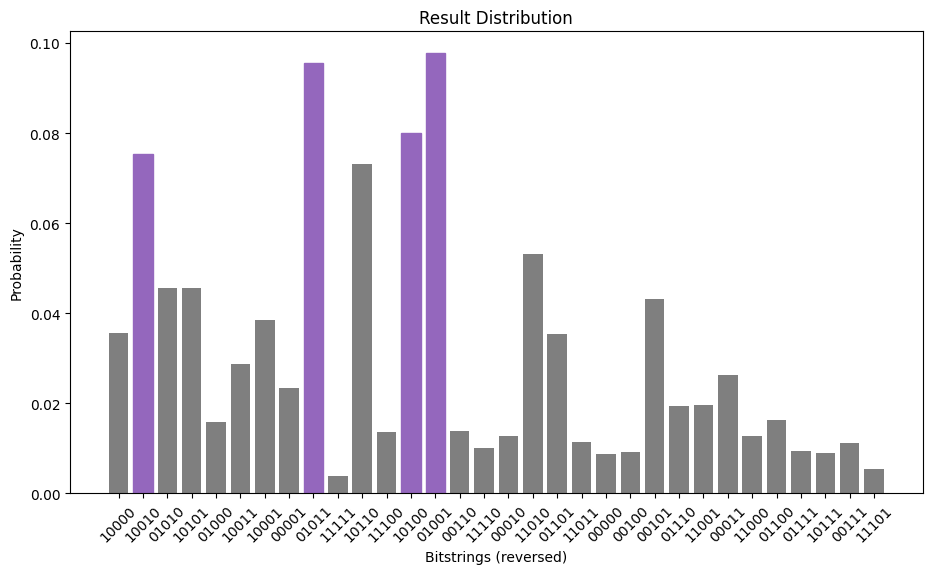

If we come back to the classical problem, the max cut in case of n = 5 is 5.

# Section 3: Alternative method without IBM Cloud

As we have mentioned many times above, the coding in section 2 heavly depend on the service provided by the IBM cloud. An alternative method that runs locally is shown in this section.

The following method requires the qiskit_algorithms package.

In [ ]:
! pip install qiskit_algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.4 MB/s eta 0:00:00


First, we start with the same plot but with a different method.

In [ ]:
import numpy as np
import networkx as nx

def create_adjacency_matrix(V, edges):
    # Initialize an empty V x V matrix with all zeros
    matrix = [[0] * V for _ in range(V)]

    # Populate the matrix based on the edges
    for edge in edges:
        u, v = edge
        matrix[u][v] = 1
        matrix[v][u] = 1  # Undirected graph

    return matrix

num_nodes = 5
edges_for_cut = [(0, 1), (2, 0), (2, 3), (3, 4), (1, 3), (2, 4)]
adj_matrix1 = create_adjacency_matrix(num_nodes, edges_for_cut)
for row in adj_matrix1:
    print(row)
print()


[0, 1, 1, 0, 0]
[1, 0, 0, 1, 0]
[1, 0, 0, 1, 1]
[0, 1, 1, 0, 1]
[0, 0, 1, 1, 0]



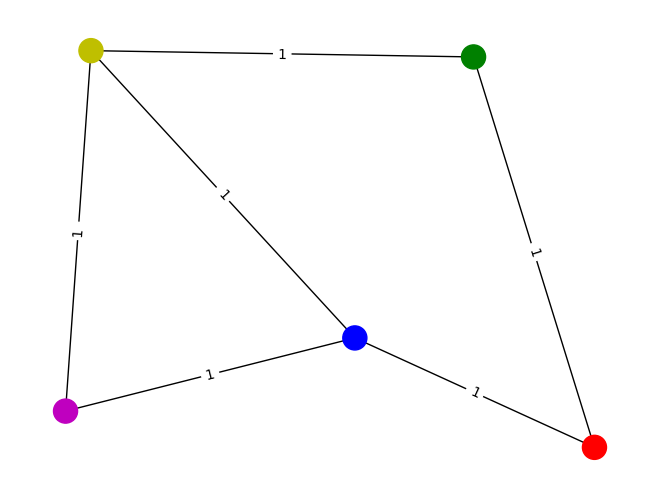

In [ ]:
w = np.array(adj_matrix1)
G = nx.from_numpy_array(w)

layout = nx.random_layout(G, seed=10)
colors = ["r", "g", "b", "y", "m"]
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

In [ ]:
from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


qubit_op, offset = get_operator(w)

In [ ]:
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals

sampler = Sampler()

def objective_value(x, w):
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)

def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)


algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by QAOA is {objective_value(x, w)}")

[0 1 1 0 0]
Objective value computed by QAOA is 5


# Section 4: A much larger scale

What if we try a much larger scale, like number of nodes = 100?

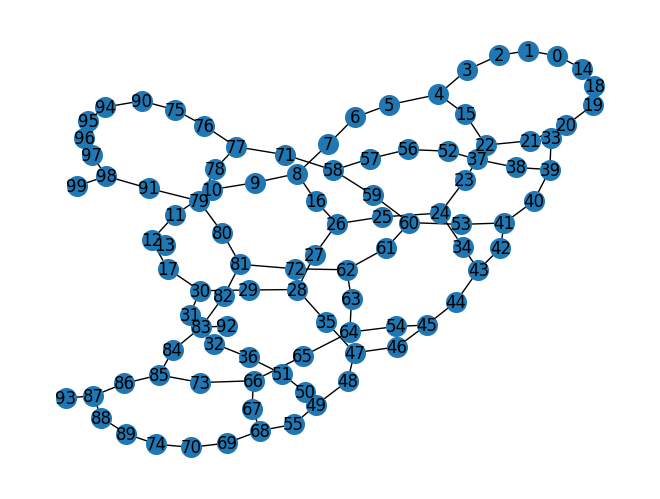

In [ ]:
n = 100  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

Similarly, we start with the Hamiltonian.

In [ ]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

With this cost function, a qaoa circuit can be produced through the QAOAAnsatz function.

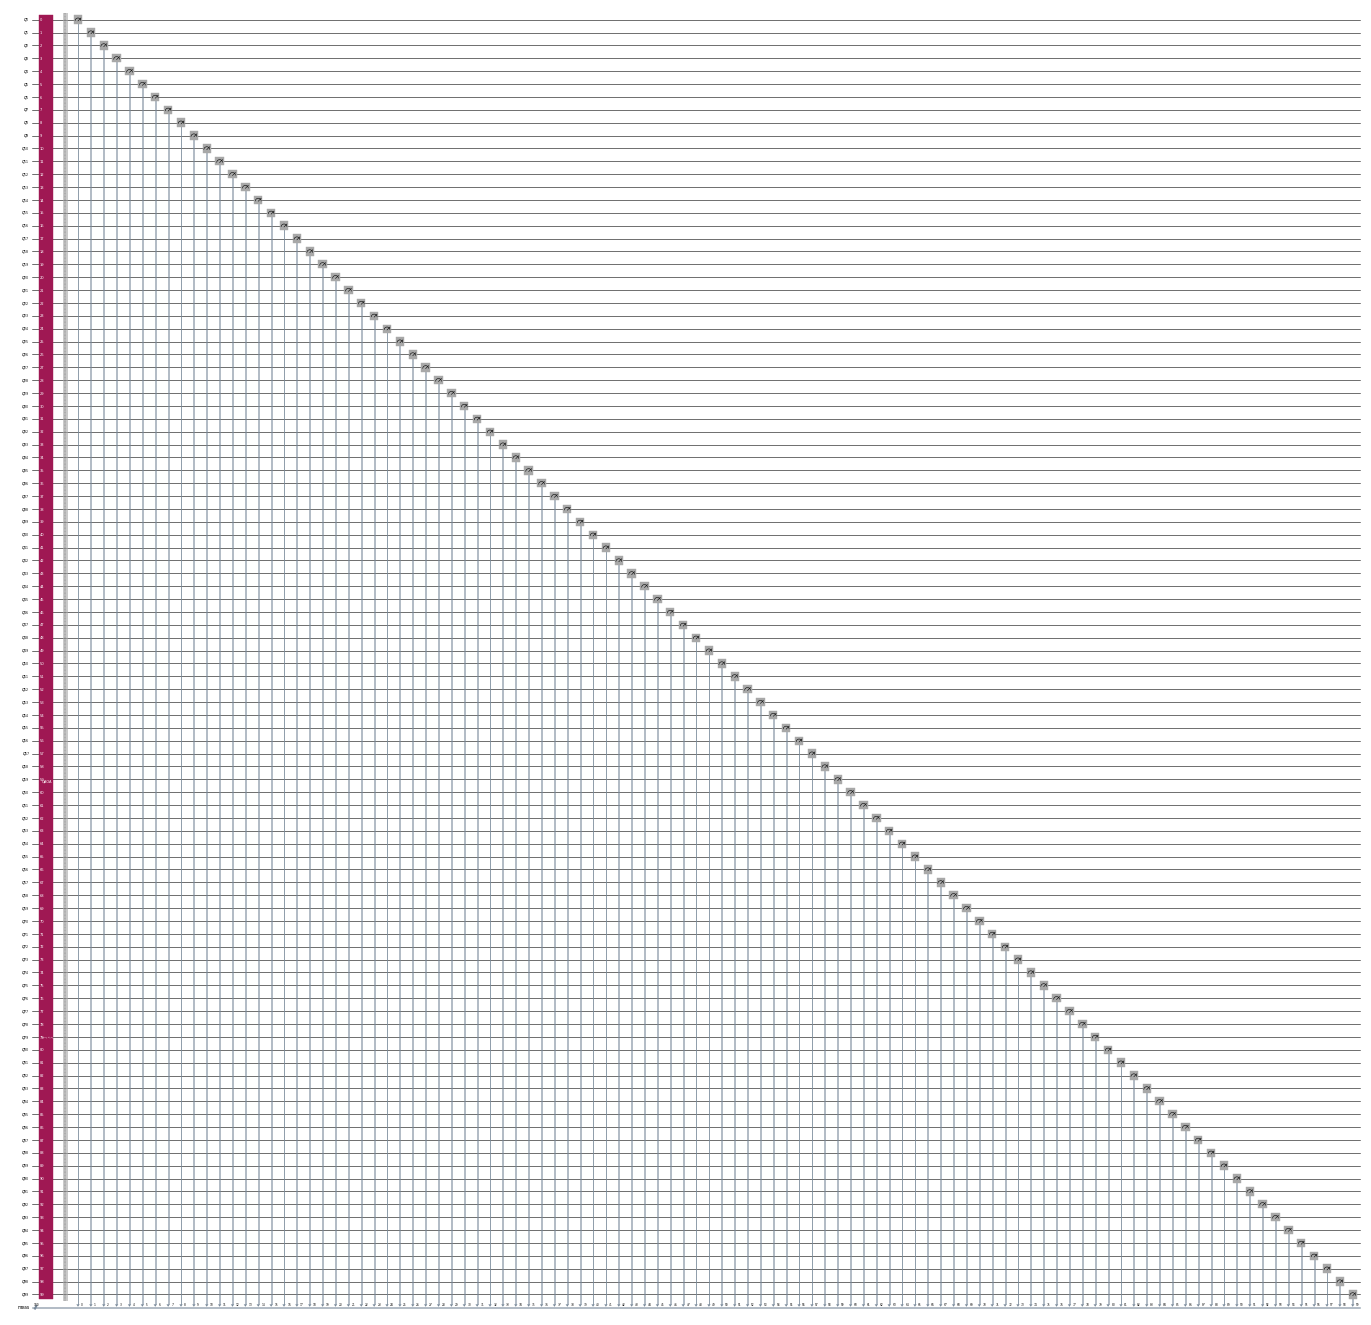

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

Obviously, the above circuit would be extremely complicated, with the same coding in section 2, but this time I will skip the running time and show the result only.
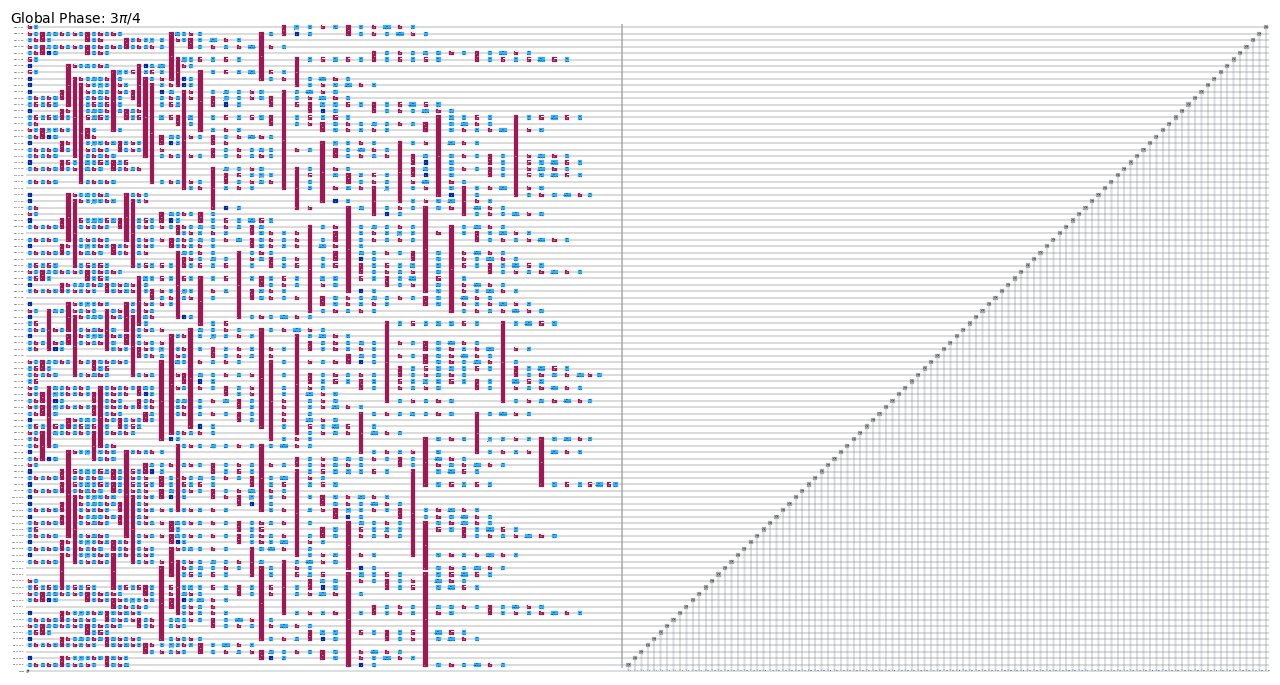

With the similar steps in section 2, the max cut can be determined.

Result bitstring: [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Number of cut: 84

Graphic illustration on the max cut:

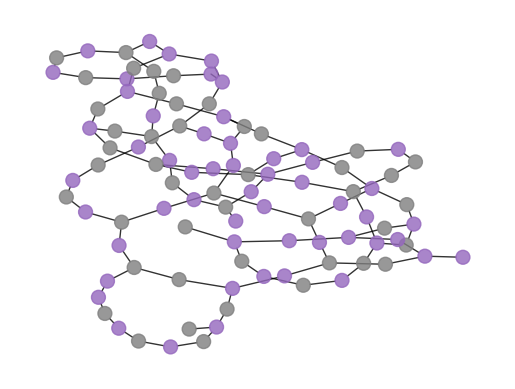

I will not try to show the histogram as it contains much more states than that could be plotted $(2^n , n = 100)$.

All the above discussion completely based on the modelling of a QPU. It is almost impossible to run this circuit in a real quantum computer. A new method is provided in

# Section 5: QAOA in QAOA

As you can see from the above example, the power of large scale QAOA is limited by the availiable quantum resources, and the complexity of the quantum circuit would increase as well. The main challenges come from the fact that manipulating a graph with n nodes requires O(n) qubits, but the most advanced quantum machines nowadays can only provide a very limited number of qubits with n ≈ 100.

Therefore, a method named as QAOA in QAOA (or QAOA$^2$) was proposed. Solving arbitrary large-scale MaxCut problems using small quantum machines is one of the most import charactistic of this algorithm.

The intial step for the QAOA is same as what we did to the 5 node problems above, so we will start with the basic mathematics for the new proposed method, the QAOA$^2$.



Standard QAOAs require n qubits to solve a MaxCut
problem with n vertices. This linear dependence sup-
presses the power of QAOA, since the accessible quantum
resources nowadays are very limited. To develop QAOAs
as large-scale problem solvers, we revisit MaxCut through
the lens of the divide-and-conquer heuristic.

In the dividing step, we partition the given graph G into
h subgraphs {Gi(Vi, Ei)}hi=1. An intuition of this partition process is exhibited in Fig. 2(a). Once the partition is completed, the MaxCut solvers are exploited to seek optimal solutions of these subgraphs in parallel.

In the conquering step, as shown in Fig. 2(b), the obtained solutions of all subgraphs are merged to obtain the global solution z of G. Since there are two solutions for each subgraph, the total number of the possible global solutions is $2^h$.

Taking into account the connections among h subgraphs, the global solution yields
$z = arg max C(z)$

The detailed proof can be found in the following link:

https://www.researchgate.net/publication/360833665_QAOA-in-QAOA_solving_large-scale_MaxCut_problems_on_small_quantum_machines



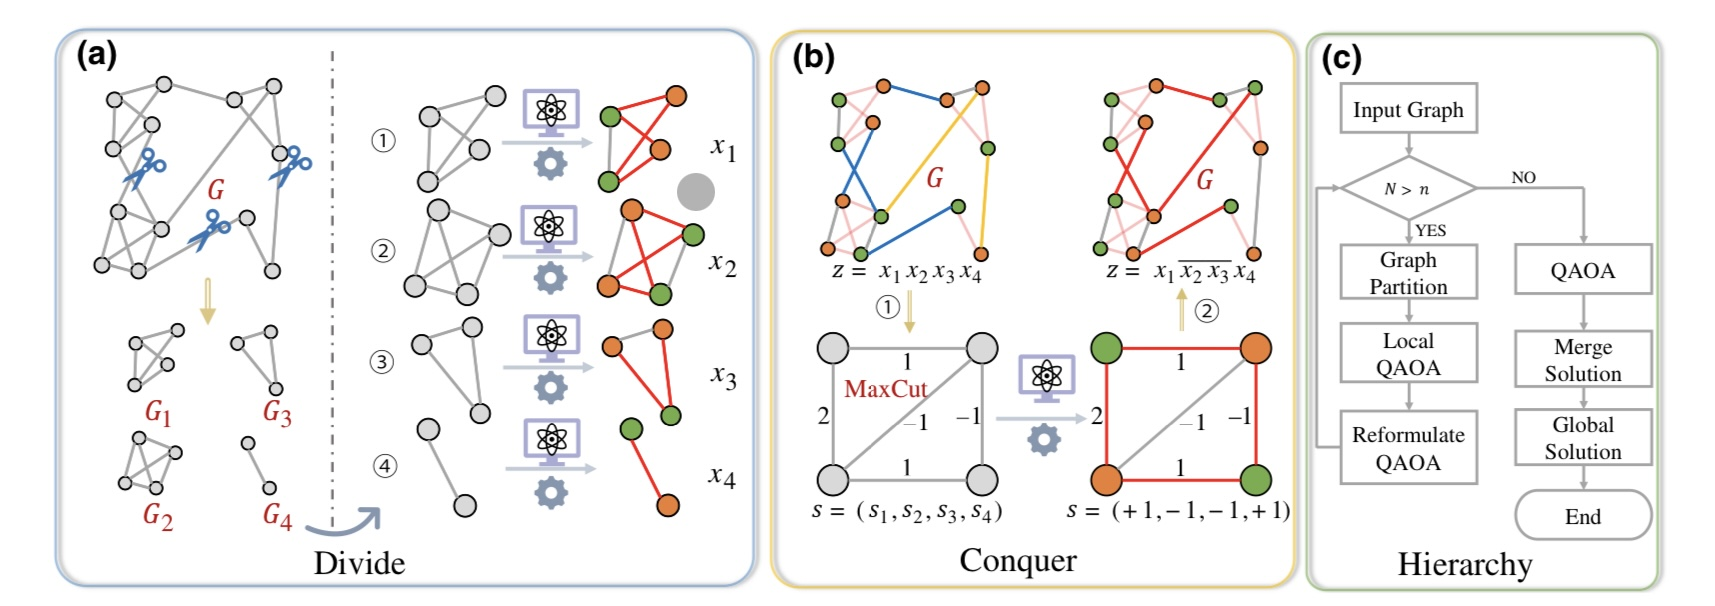

FIG. 2. Scheme of QAOA$^2$. (a) A graph is partitioned into four parts, where each one is no larger than the available number of qubits (e.g., four qubits). Then the adopted MaxCut solvers are applied to all subgraphs in parallel. The green node refers to bit +1 and the orange node refers to bit −1. The cut edges are in red. (b) The first step highlighted by the brown arrow refers to merging local solutions of all subgraphs and calculating the value of cut between subgraphs. Yellow lines refer to “cut” and blue lines refer to “uncut.” The lower left plot indicates that the accommodation of local solutions can be reformulated as a new MaxCut problem with four nodes. The first step highlighted by the brown arrow means that MaxCut solvers are applied to solve this new problem. Then, local solutions are merged according to the solution of s. (c) An extremely large MaxCut can be solved by applying QAOA$^2$ in a hierarchical way. When the graph size is above the limitation of qubits, it is partitioned and solved locally, and then reformed as a new MaxCut until its size is no larger than the available number of qubits. After all optimizations, low-level local solutions are merged according to high-level solutions.

The following coding aims to provide a borad understading on the QAOA in pennylane and how to develop it to QAOA$^2$.

In [ ]:
!pip install pennylane

First, define few functions that would be used later.

In [ ]:
from pennylane import numpy as np
import math
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

class Graph():
    '''
    A graph is saved in both an adjoint matrix and edge list.
    '''
    def __init__(self, v:list=None, edges:list=None,adjoint=None) -> None:

        self.v = v
        self.n_v = len(v)
        self.e = edges
        self.adj = adjoint

        if self.adj is None:
            self._edges_to_adjoint()

        if self.e is None:
            self._adjoint_to_edges()

        self.v2i = {v[i]:i for i in range(self.n_v)}

    def _edges_to_adjoint(self) -> None:
        self.adj = np.zeros((self.n_v, self.n_v), requires_grad=False)
        for edge in self.e:
            v1 = edge[0]
            v2 = edge[1]
            w = edge[2]
            self.adj[v1][v2] = w
            self.adj[v2][v1] = w

    def _adjoint_to_edges(self) -> None:
        self.e = []

        for i in range(self.n_v):
            for j in range(i+1, self.n_v):
                if self.adj[i][j] != 0:
                    self.e.append((i, j, self.adj[i][j].item()))

    def graph_partition(self, n:int, policy:str='random',n_sub=1) -> list:
        '''
        n : Allowable qubit number.

        policy : Partition strategy. Default is 'random'. Another is 'modularity', which partitions graph basing on greedy modularity method.

        n_sub : number of subgraphs. Only use in 'modularity'.
        '''
        H = []
        v = self.v

        if policy == 'modularity':
            G = nx.Graph()
            G.add_nodes_from(v)
            for x in self.e:
                G.add_edge(x[0],x[1],weight=x[2])
            c = greedy_modularity_communities(G,n_communities=n_sub)
            sub_list = [list(x) for x in c]
            for x in sub_list:
                if len(x) > n:
                    n_ssub = math.ceil(len(x) / n)

                    ssub_list = [x[n*i:n*(i+1)] for i in range(n_ssub)]
                    for i in range(n_ssub):
                        A = self.adj[ssub_list[i]][:,ssub_list[i]]
                        H.append(Graph(v=ssub_list[i], adjoint=A))
                else:
                    A = self.adj[x][:,x]
                    H.append(Graph(v=x, adjoint=A))
        if policy == 'random':
            n_sub = math.ceil(self.n_v / n)
            np.random.shuffle(v)
            sub_list = [v[n*i:n*(i+1)] for i in range(n_sub)]
            for i in range(n_sub):
                A = self.adj[sub_list[i]][:,sub_list[i]]
                H.append(Graph(v=sub_list[i], adjoint=A))
        return H


Also, use pennylane to achieve the QAOA again.

In [ ]:
import pennylane as qml
from tqdm import tqdm
import collections

def qaoa(G:Graph, shots:int=1000, n_layers:int=1, const=0, sample_method:str='max'):
    '''
    standard qaoa for max cut
    --------------------------
    G : Graph

    shots : number of circuit shots

    n_layers : number of QAOA layers

    const : constant in max cut objective function

    sample_method : 'max' return the bitstring with largest cut value


    Return cut value and solution
    '''
    n_wires = G.n_v
    edges = G.e
    # subgraph with no edges, any partition is optimal
    if edges == []:
        return const ,format(0,"0{}b".format(n_wires))[::-1]

    # during optimization phase we use default number of shots
    # dev is for optimization phase
    dev = qml.device('lightning.qubit', wires=n_wires,shots=shots)

    # cost Hamiltonian
    coeffs = []
    obs = []
    for edge in edges:
        coeffs.append(0.5 * edge[2])
        obs.append( qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1]) )
    H_C = qml.Hamiltonian(coeffs, obs)

    # mixer Hamiltonian
    coeffs = []
    obs = []
    for i in range(n_wires):
        coeffs.append(1.)
        obs.append(qml.PauliX(i))
    H_B = qml.Hamiltonian(coeffs, obs)

    def qaoa_layer(gamma,beta):
        qml.templates.subroutines.ApproxTimeEvolution(H_C,gamma,1)
        qml.templates.subroutines.ApproxTimeEvolution(H_B,beta,1)

    def _circuit(n_layers=1):

        @qml.qnode(dev)
        def circuit(params):
            # apply Hadamards to get the n qubit |+> state
            for wire in range(n_wires):
                qml.Hadamard(wire)
            # p instances of unitary operators

            qml.layer(qaoa_layer, n_layers, params[0], params[1])
            return qml.expval(H_C)

            # during the optimization phase we are evaluating a term
            # in the objective using expval
        return circuit

    # initializing parameters
    init_params = np.ones((2, n_layers))
    opt = qml.GradientDescentOptimizer()
    #opt = qml.QNGOptimizer(0.01)
    params = init_params
    steps = 20
    for _ in range(steps):
        params = opt.step(_circuit(n_layers=n_layers), params)


    # measure in computational basis, 0-2^n-1 represent each basis
    def comp_basis_measurement(wires):
        n_wires = len(wires)
        return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

    dev2 = qml.device('lightning.qubit', wires=n_wires, shots=1000)
    @qml.qnode(dev2)
    def circuit2(params, n_layers=1):
        # apply Hadamards to get the n qubit |+> state
        for wire in range(n_wires):
            qml.Hadamard(wires=wire)

        qml.layer(qaoa_layer, n_layers, params[0], params[1])

        return [qml.sample(qml.PauliZ(i)) for i in range(n_wires)]

    #
    # sample after optimization to find the most frequent bitstring
    bit_strings = []
    samples = circuit2(params, n_layers=n_layers)

    # samples is (n_samples, n_wires) ndarray
    for x in samples.T:
        bitlist = [str(int((i + 1)/2)) for i in x]
        bitstring = ''.join(bitlist)
        bit_strings.append(bitstring)

    counts = collections.Counter(bit_strings)
    # use the bitstring with min obj
    if sample_method == 'max':
        sol = None
        obj = 10e6
        for bitstring in counts.keys():
            #print(bitstring)
            obj_temp = 0
            for edge in edges:
                obj_temp += 0.5 * edge[2] * (2*( bitstring[ edge[0] ]==bitstring[ edge[1] ] )-1)
            if obj_temp < obj:
                obj = obj_temp
                sol = bitstring
        return const - obj, sol

    most_freq_bit_string = counts.most_common(1)
    sol = most_freq_bit_string[0][0]
    obj = 0
    for edge in edges:
        obj += 0.5 * edge[2] * (2*( sol[ edge[0] ]==sol[ edge[1] ] )-1)
    return const - obj, sol


Then, with the above prepartion, the coding for QAOA in QAOA is shown.

In [ ]:
from pennylane import numpy as np
import math
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

class Graph():
    '''
    A graph is saved in both an adjoint matrix and edge list.
    '''
    def __init__(self, v:list=None, edges:list=None,adjoint=None) -> None:

        self.v = v
        self.n_v = len(v)
        self.e = edges
        self.adj = adjoint

        if self.adj is None:
            self._edges_to_adjoint()

        if self.e is None:
            self._adjoint_to_edges()

        self.v2i = {v[i]:i for i in range(self.n_v)}

    def _edges_to_adjoint(self) -> None:
        self.adj = np.zeros((self.n_v, self.n_v), requires_grad=False)
        for edge in self.e:
            v1 = edge[0]
            v2 = edge[1]
            w = edge[2]
            self.adj[v1][v2] = w
            self.adj[v2][v1] = w

    def _adjoint_to_edges(self) -> None:
        self.e = []

        for i in range(self.n_v):
            for j in range(i+1, self.n_v):
                if self.adj[i][j] != 0:
                    self.e.append((i, j, self.adj[i][j].item()))

    def graph_partition(self, n:int, policy:str='random',n_sub=1) -> list:
        '''
        n : Allowable qubit number.

        policy : Partition strategy. Default is 'random'. Another is 'modularity', which partitions graph basing on greedy modularity method.

        n_sub : number of subgraphs. Only use in 'modularity'.
        '''
        H = []
        v = self.v

        if policy == 'modularity':
            G = nx.Graph()
            G.add_nodes_from(v)
            for x in self.e:
                G.add_edge(x[0],x[1],weight=x[2])
            c = greedy_modularity_communities(G,n_communities=n_sub)
            sub_list = [list(x) for x in c]
            for x in sub_list:
                if len(x) > n:
                    n_ssub = math.ceil(len(x) / n)

                    ssub_list = [x[n*i:n*(i+1)] for i in range(n_ssub)]
                    for i in range(n_ssub):
                        A = self.adj[ssub_list[i]][:,ssub_list[i]]
                        H.append(Graph(v=ssub_list[i], adjoint=A))
                else:
                    A = self.adj[x][:,x]
                    H.append(Graph(v=x, adjoint=A))
        if policy == 'random':
            n_sub = math.ceil(self.n_v / n)
            np.random.shuffle(v)
            sub_list = [v[n*i:n*(i+1)] for i in range(n_sub)]
            for i in range(n_sub):
                A = self.adj[sub_list[i]][:,sub_list[i]]
                H.append(Graph(v=sub_list[i], adjoint=A))
        return H





In conclusion, this report focuses on